In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [9]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [10]:
tf.keras.backend.set_floatx("float64")

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


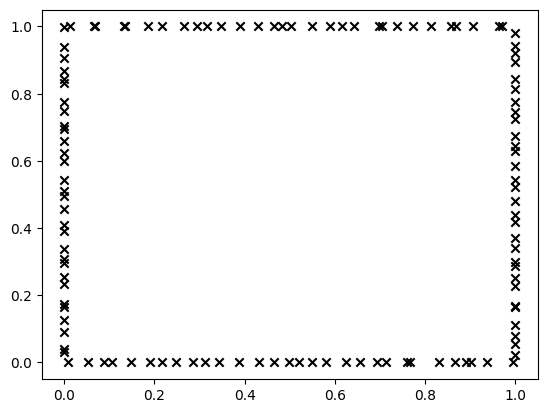

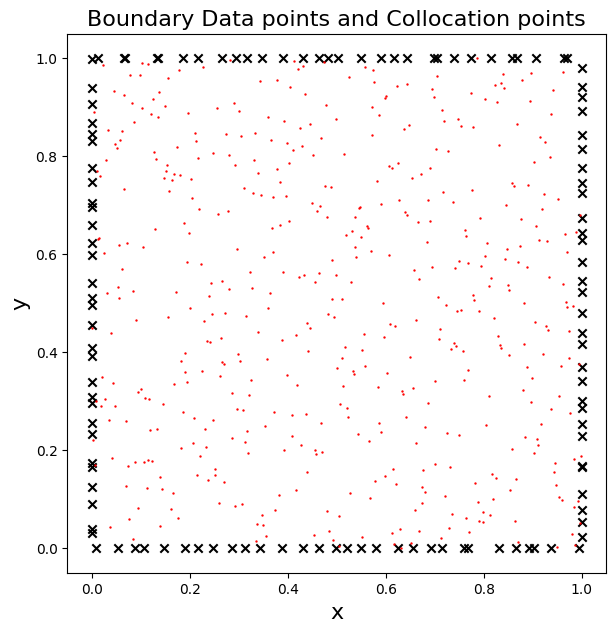

In [11]:
# .......................................
# We solve Poissons equation Delta u = f
#  for different f (x,y)
#.........................................

# Select the solution you want among 5 possibilities ........................
# in agreement with different f(x,y) .... se below for selecting equation residual
# ...............................................................................

coef= 1.

@tf.function
def tru(x, y):
    tru = tf.exp(x*y)
    #tru=tf.exp(x)*tf.sin(y)+1/4*(x*x+y*y)
    #tru=tf.sinh(x)
    #tru=tf.exp(x*x+y*y)
    #tru=tf.exp(x*y)+coef*tf.sinh(x)
    return tru

# Select associated x derivatives .........
@tf.function
def trudx(x, y):
    trudx = tf.exp(x*y)*y    
    #trudx=tf.exp(x)*tf.sin(y)+1/2*x
    #trudx=tf.cosh(x)    
    #trudx=tf.exp(x*x+y*y)*2*x    
    #trudx=y*tf.exp(x*y)+coef*tf.cosh(x) 
    return trudx
    
# Select y derviatives .....
@tf.function
def trudy(x, y):
    trudy = tf.exp(x*y)*x    
    #trudy=tf.exp(x)*tf.cos(y)+1/2*y    
    #trudy=0    
    #trudy=tf.exp(x*x+y*y)*2*y  
    #trudy=x*tf.exp(x*y)
    return trudy


### data generation .......
rmax=1
lmax= 1

n_bc = 4
n_data_per_bc = 30

# Define the datapoints ............;
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc ,n_data_per_bc , 5])

for i, j in zip(range(n_bc), [0., 1., 0, 1.]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    
    if i < 2:
        data[i, :, 0] = j + 0.
        data[i, :, 1] = points - 0.
    else:
        data[i, :, 0] = points + 0.
        data[i, :, 1] = j - 0.

data[:, :, 0] = rmax * data[:, :, 0] 
data[:, :, 1] = lmax*data[:, :, 1]

print(data[3,:,1])

# Values of data , derivative/x , and derivative/y ...
for j in range(0,n_data_per_bc):    
    # bord x = 0    
    data[0, j, 2] = tru(data[0, j, 0] ,data[0, j, 1] )
    data[0, j, 3] = trudx(data[0, j, 0] ,data[0, j, 1] )
    data[0, j, 4] = trudy(data[0, j, 0] ,data[0, j, 1] )

    # utilisé ......(x=1)
    data[1, j, 2] = tru(data[1, j, 0] ,data[1, j, 1] )
    data[1, j, 3] = trudx(data[1, j, 0] ,data[1, j, 1] )
    data[1, j, 4] = trudy(data[1, j, 0] ,data[1, j, 1] )
    
    # bord y = 0 ....
    data[2,j,2] = tru(data[2, j, 0] ,data[2, j, 1] )
    data[2,j,3] = trudx(data[2, j, 0] ,data[2, j, 1] )
    data[2,j,4] = trudy(data[2, j, 0] ,data[2, j, 1] )

    # bord y = 1 ......
    data[3,j,2] = tru(data[3, j, 0] ,data[3, j, 1] )
    data[3,j,3] = trudx(data[3, j, 0] ,data[3, j, 1] )
    data[3,j,4] = trudy(data[3, j, 0] ,data[3, j, 1] )


data = data.reshape(n_data_per_bc * n_bc, 5)

# t_d are data values, t_dx and td_y derivatives wrt x and y respectively .....
x_d, y_d, t_d, t_dx, t_dy = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]])

plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.show()

# collocation points .................
Nc = 500
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = rmax*colloc[:, 0] 
colloc[:, 1] = lmax*colloc[:, 1] 



#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#
plt.figure("", figsize=(7, 7))
plt.title("Boundary Data points and Collocation points",fontsize=16)
plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:,0], colloc[:,1], s=2, marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

#

x_c, y_c, x_d, y_d, t_d, t_dx, t_dy = map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d, t_dx, t_dy])

In [12]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=6, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [13]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 6, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [14]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u
    
@tf.function
def uderx(x, y):
    u = model(tf.concat([x, y], axis=1))
    uderx = tf.gradients(u, x)[0]
    return uderx

@tf.function
def udery(x, y):
    u = model(tf.concat([x, y], axis=1))
    udery = tf.gradients(u,y)[0]
    return udery



In [15]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    # Select the residual equation ....
    F = u_xx + u_yy - (x*x+y*y)*tf.exp(x*y)
    #F= u_xx + u_yy - 1
    #F = u_xx + u_yy - tf.sinh(x)
    #F = u_xx+u_yy -4*(x*x+y*y+1)*tf.exp(x*x+y*y)
    #F=u_xx+u_yy-(x*x+y*y)*tf.exp(x*y)-coef*tf.sinh(x)
    
    retour = tf.reduce_mean(tf.square(F)) 
    return retour



In [16]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

@tf.function
def msex1(y, y_):
    # MSE only for boundary at x =  .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[0,:]
    yrr_= yr_[0,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msex2(y, y_):
    # MSE only for boundary at x =  .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[1,:]
    yrr_= yr_[1,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour


@tf.function
def msey1(y, y_):
    # MSE only for 2 boundaries at y = .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[2,:]
    yrr_= yr_[2,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey2(y, y_):
    # MSE only for 2 boundaries at y = .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[3,:]
    yrr_= yr_[3,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour



In [ ]:
loss = 0
epochs = 60000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        Tderx_= uderx(x_d, y_d)
        Tdery_ = udery(x_d, y_d)
        
        #loss on PDE
        L = 1*f(x_c, y_c)

        # Select the loss on data .......
        #l = mse(t_d, T_)
        l = 0
        #l = 1*msex1(t_d, T_) +  1*msey1(t_d, T_) + 1*msey2(t_d, T_) + 0*msex2(t_d, T_)
        
        # Select the loss on data derivatives wrt x or/and wrt y....
        #l = l + 1*msex1(t_dx, Tderx_) + 1*msex2(t_dx, Tderx_) + 1*msey1(t_dx, Tderx_) + 1*msey2(t_dx, Tderx_)
        #l = l + 1*msex1(t_dy, Tdery_) + 1*msex2(t_dy, Tdery_) + 1*msey1(t_dy, Tdery_) + 1*msey2(t_dy, Tdery_)

        l = mse(t_d, T_) 
        loss = L + l
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    #loss_values = np.append(loss_values, loss)
    #L_values = np.append(L_values, L)
    #l_values = np.append(l_values, l)
    
    
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.9f}")
        loss_values = np.append(loss_values, loss)
        L_values = np.append(L_values, L)
        l_values = np.append(l_values, l)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
#plt.semilogy(loss_values, label=model.name)
plt.semilogy(loss_values, label="Total loss")
plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()

    0, 4.153067218
  100, 1.381758596
  200, 0.709581023
  300, 0.552209162
  400, 0.392936020
  500, 0.274257758
  600, 0.163834225
  700, 0.090797143
  800, 0.071963914
  900, 0.059777581
 1000, 0.050523292
 1100, 0.042559082
 1200, 0.035516976
 1300, 0.030846620
 1400, 0.025285425
 1500, 0.021874895
 1600, 0.019052612
 1700, 0.016781714
 1800, 0.014763352
 1900, 0.012825222
 2000, 0.011034339
 2100, 0.009322464
 2200, 0.007642131
 2300, 0.006244191
 2400, 0.005078244
 2500, 0.004167163
 2600, 0.003533028
 2700, 0.003070217
 2800, 0.002710246
 2900, 0.002418424
 3000, 0.002180605
 3100, 0.001982693
 3200, 0.001810358
 3300, 0.001653683
 3400, 0.001509886
 3500, 0.001401352
 3600, 0.001269012
 3700, 0.001164532
 3800, 0.001066445
 3900, 0.000974575
 4000, 0.000893289
 4100, 0.000819735
 4200, 0.000752516
 4300, 0.000689816
 4400, 0.000631637
 4500, 0.000580794
 4600, 0.000536751
 4700, 0.000496186
 4800, 0.000458655
 4900, 0.000424225
 5000, 0.000395668
 5100, 0.000370405
 5200, 0.000

In [34]:
# Define a grid of points in order to evaluate and plot the solution ....
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

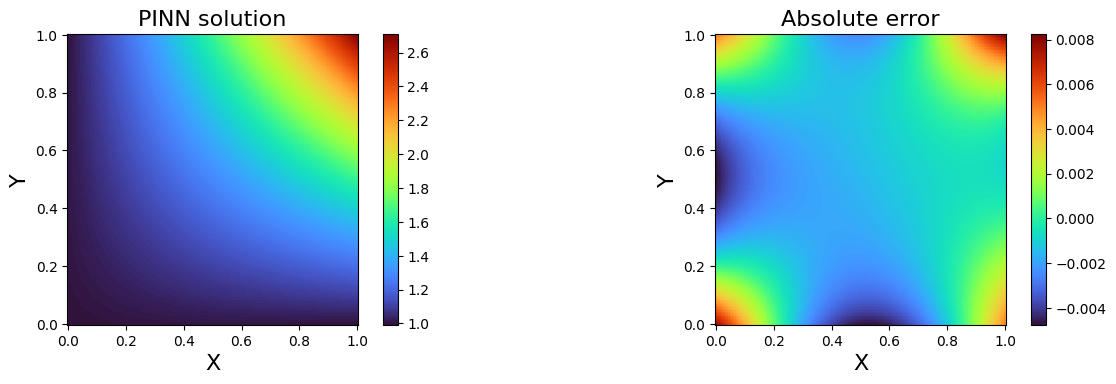

In [35]:
### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
lim1=lmax
lim2=rmax

X = np.linspace(0.000, lim2, n)
Y = np.linspace(0, lim1, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# Predicted solution by the network .....
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
plt.subplot(221)
plt.pcolormesh(X0, Y0, S2, cmap="turbo")
#plt.contour(X0, Y0, S2,18,linestyles='dashed',linewidths=1.5)
plt.colorbar(pad=-0.3)
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", label="BDP")
#plt.scatter(colloc[:,0], colloc[:,1], marker=".", c="b")
plt.xlabel("X",fontsize=16)
plt.ylabel("Y",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(0, lim1)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
plt.axis("square")

#plt.show()
#

#plt.figure("", figsize=(14, 7))
# True/exact solution to evaluate the error ...
TT = tru(X0,Y0)

TT2 = (TT - S2) 
#TT2 = (TT - S2)/TT

plt.subplot(222)
plt.pcolormesh(X0, Y0, TT2, cmap="turbo")
#plt.contour(X0, Y0, TT2,21)
plt.colorbar(pad=-0.3)
plt.xlabel("X",fontsize=16)
plt.ylabel("Y",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(0, lim1)
plt.title("Absolute error", fontsize=16)
#plt.title("Relative error", fontsize=16)
plt.tight_layout()
plt.axis("square")

plt.show()
#



[0, 49, 99, 149, 199]


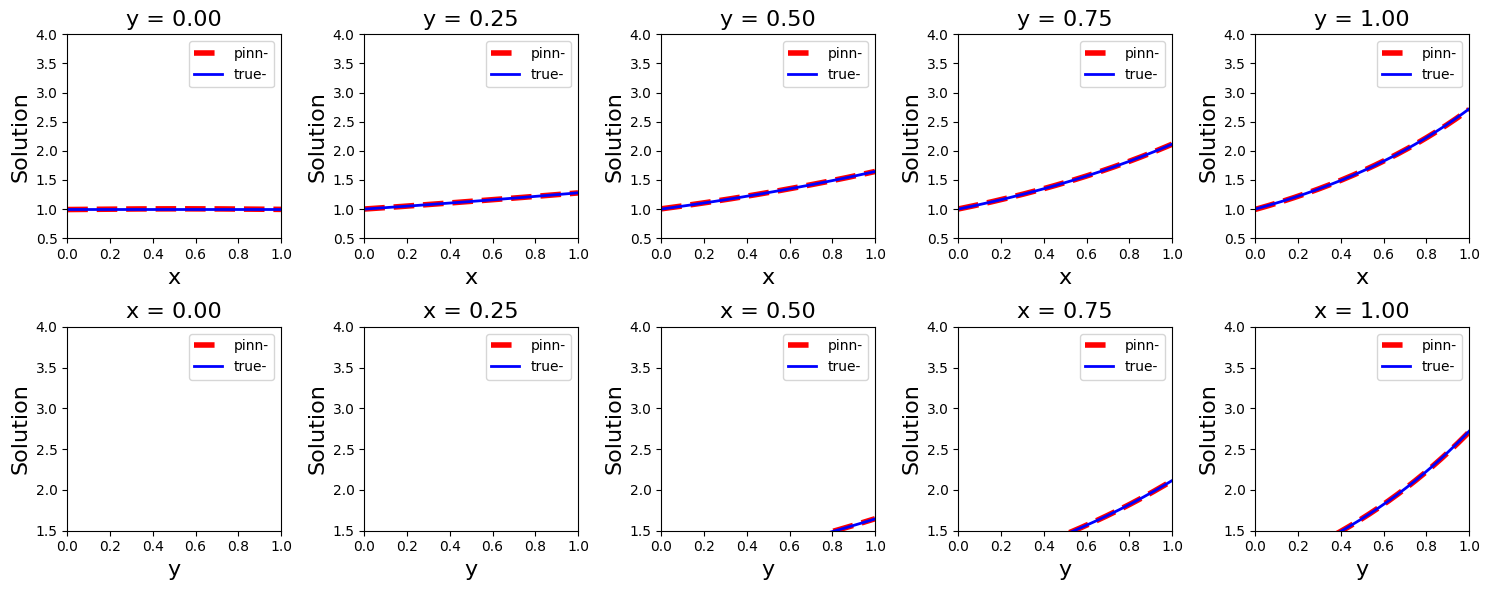

In [36]:
# To compare cuts ........ manetic field B_y ...
X = np.linspace(0, lim2, n)
Y = np.linspace(0, +lim1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

x = np.linspace(0, lim2, n)
y = np.linspace(0, lim1, n)
x, y = np.meshgrid(x, y)


Scomp = u(X_T, Y_T)
S = Scomp
S = S.numpy().reshape(n, n)
S_ = S.reshape([n, n])
# True B_y .................
T_ = tru(x,y)

height = 3
frames_val = np.array([0, 0.25, 0.5, 0.75, 1])
frames = [*map(int, (frames_val + 0)/lmax/1 * (n-1))]

print (frames)

fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn-")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="true-")
    plt.ylim(0.5, 4)
    plt.xlim(0, lim2)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

height = 3
frames_val = np.array([0, 0.25, 0.5, 0.75, 1])
frames = [*map(int, (frames_val + 0)/rmax/1 * (n-1))]

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y0[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn-")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="true-")
    plt.ylim(1.5, 4)
    plt.xlim(0, lim1)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


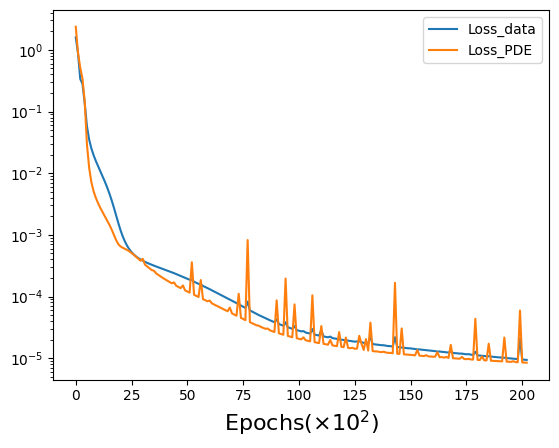

In [33]:
plt.legend()
plt.semilogy(l_values, label='Loss_data')
plt.legend()

plt.semilogy(L_values, label='Loss_PDE')
plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()